# **Ashutosh Singh - 17CH30004 - Assignment 1 - Advanced Machine Learning**

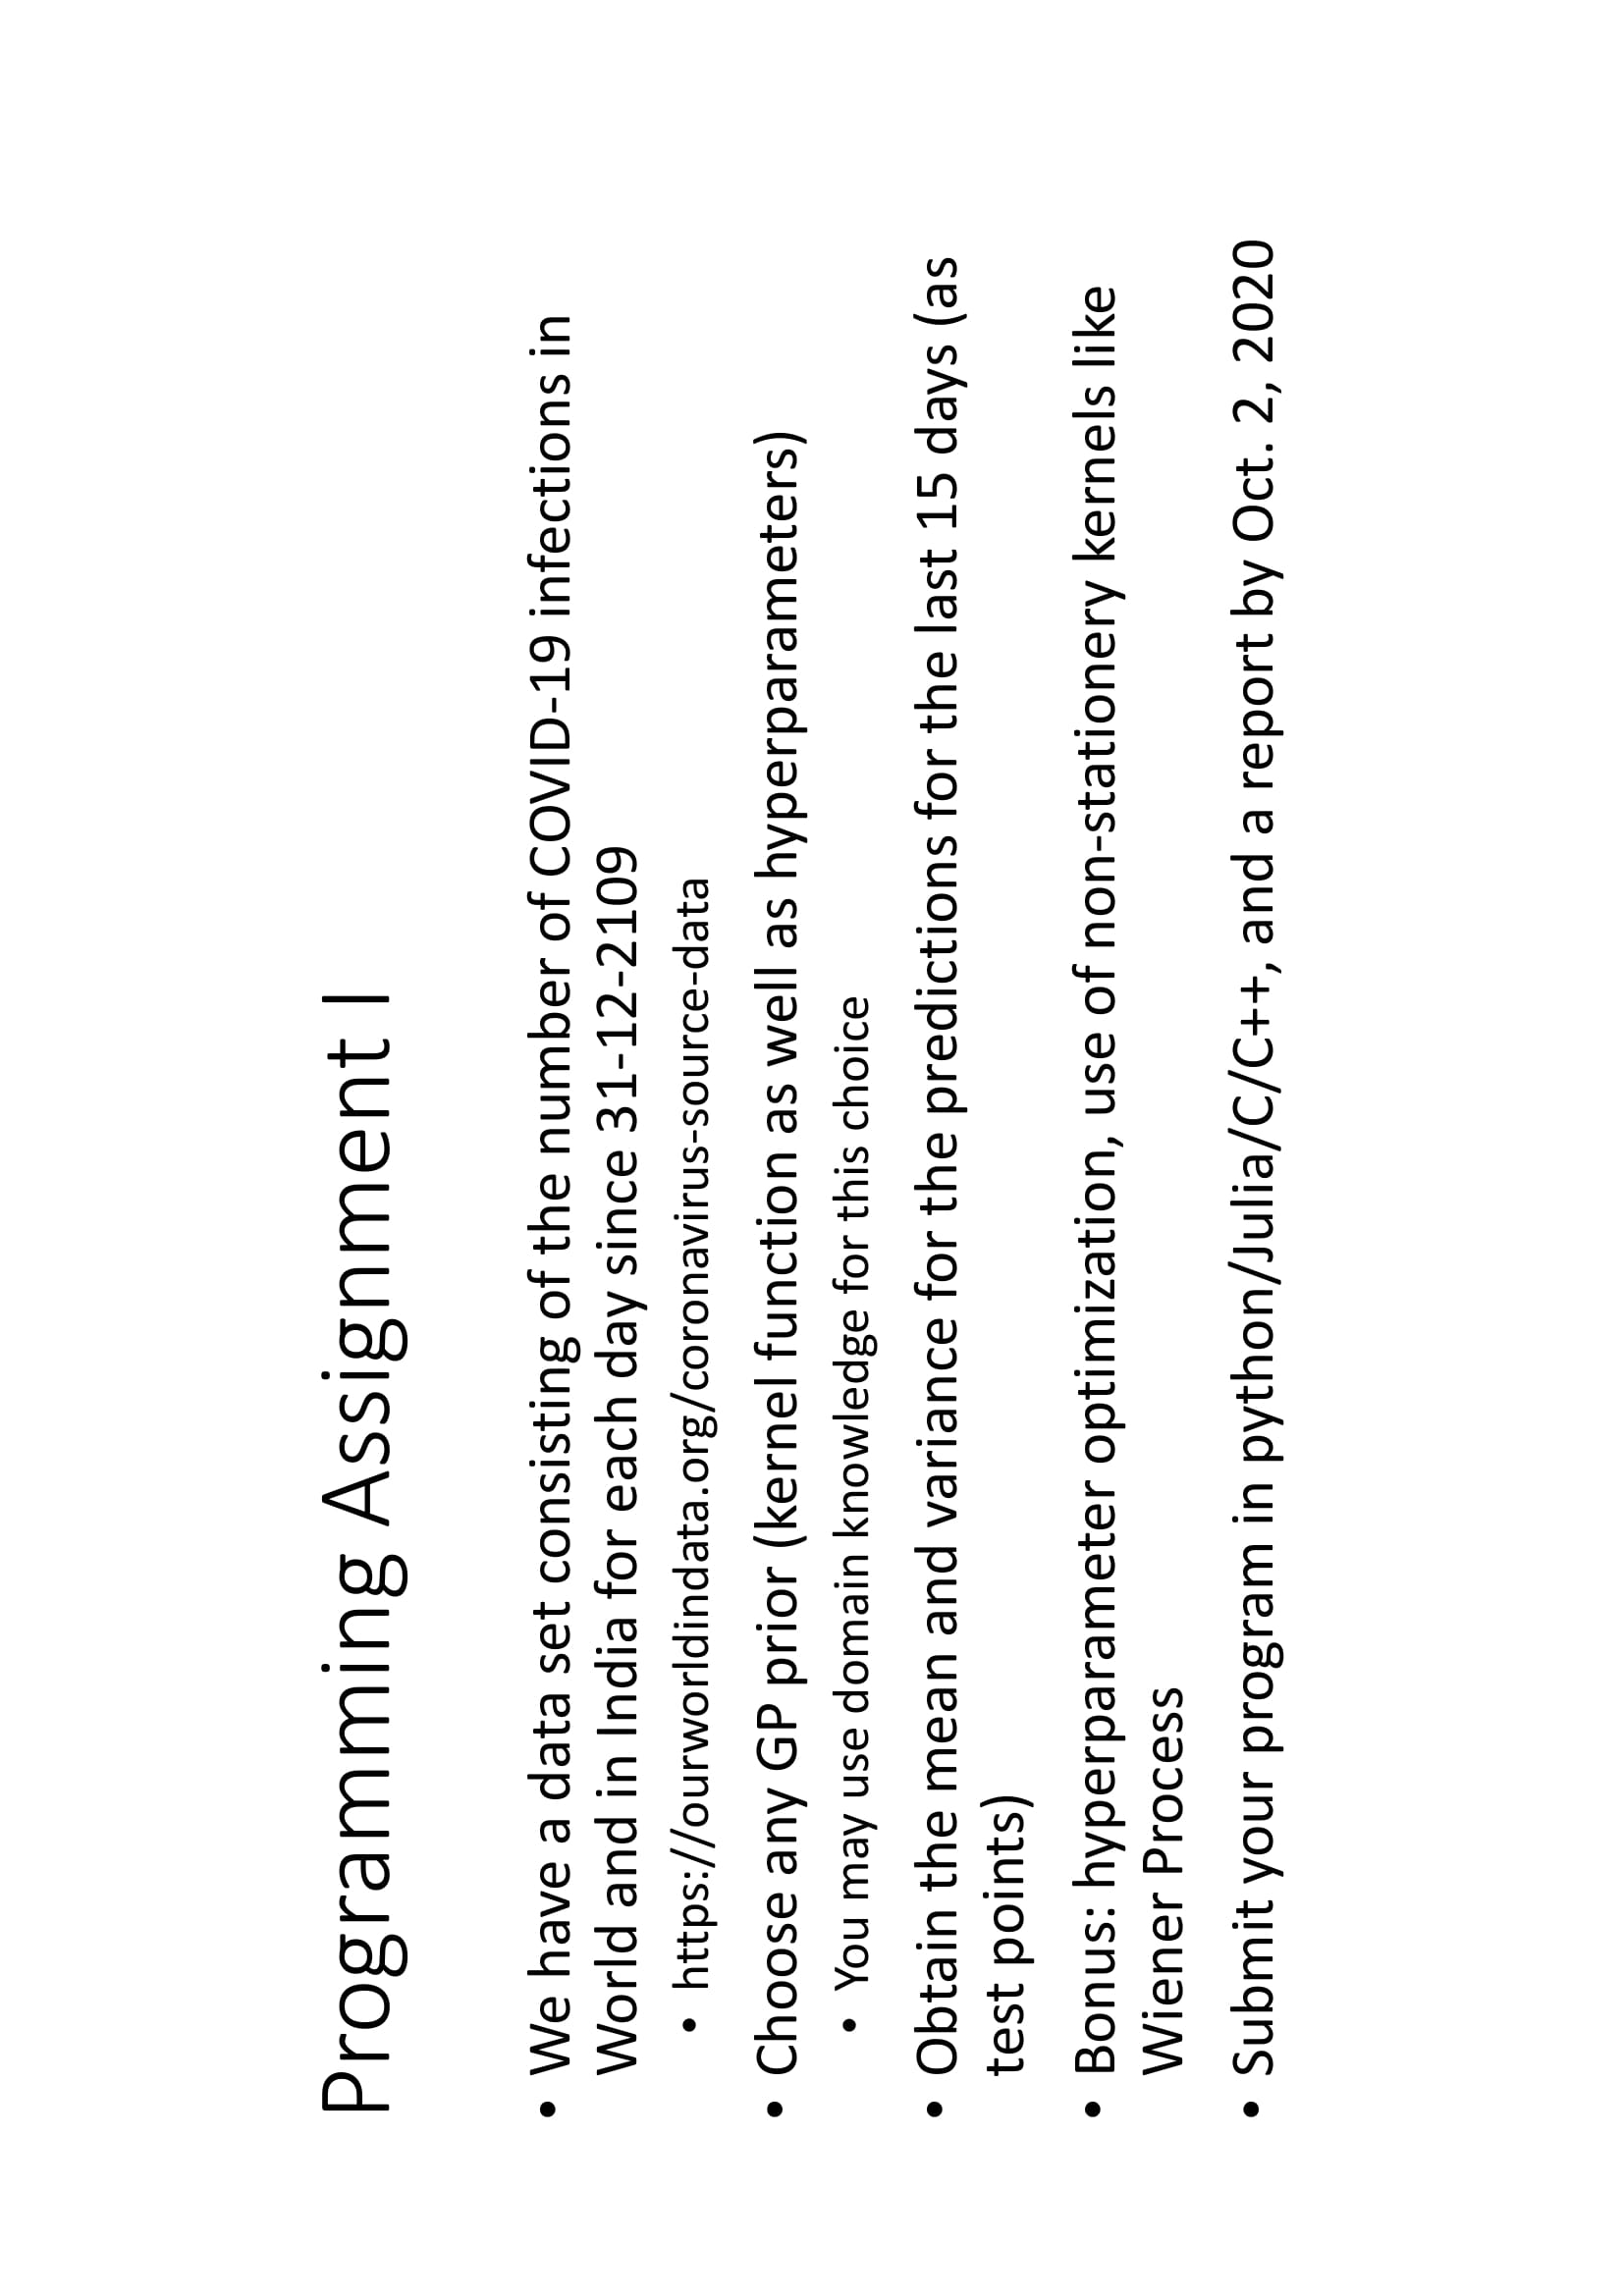

**Theory**

> In supervised learning, we often use parametric models p(y|X,θ) to explain data and infer optimal values of parameter θ via maximum likelihood or maximum a posteriori estimation. If needed we can also infer a full posterior distribution p(θ|X,y) instead of a point estimate θ^. 

With increasing data complexity, models with a higher number of parameters are usually needed to explain data reasonably well. Methods that use models with a fixed number of parameters are called parametric methods.

> Gaussian Process : It is a collection of Random Variables, any finite number of which have (consistent) Gaussian distributions.
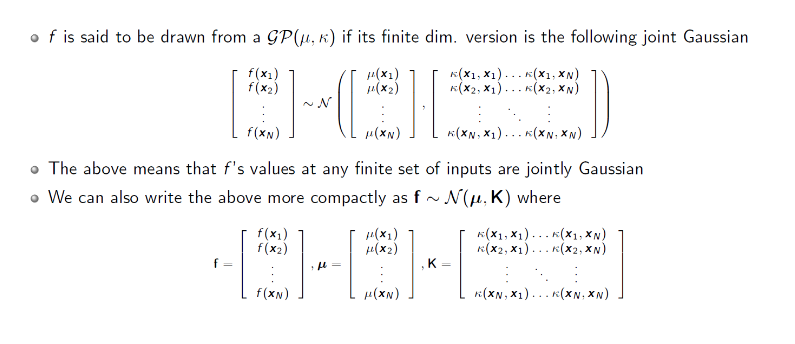


A Gaussian process is a random process where any point x∈Rd is assigned a random variable f(x) and where the joint distribution of a finite number of these variables p(f(x1),…,f(xN)) is itself Gaussian:
p(f|X)=N(f|μ,K)(1)

> **p(f | X) = N(f | μ, K)**         -------------------------------------------------         (1)


In Equation (1):

1.   f=(f(x1),…,f(xN)), μ=(m(x1),…,m(xN)) and Kij=κ(xi,xj).
2.   m is the mean function and it is common to use m(x)=0 as GPs are flexible enough to model the mean arbitrarily well.
3. κ is a positive definite kernel function or covariance function.
4. Thus, a Gaussian process is a distribution over functions whose shape (smoothness, …) is defined by K.






# **Approach and Code**



1.   We begin by import of various libraries and the upload of the data needed.



**Imports**

*   Pandas - For data handling and exploration
*   Numpy - For matrix operations
*   Matplotlib and Seaborn - Plotting Libraries

*   linalg - For implementing Linear Algebraic Mehtods - Cholesky Decomposition, Determinant and least-squares solution to a linear matrix equation
*   scipy.optimize - minimize - To minimize the negative log likelihood
*   sklearn.metrics - For fit evaluation (Root Mean Squared Error)

In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from numpy.linalg import cholesky, det, lstsq
from scipy.optimize import minimize
from sklearn.metrics import r2_score, mean_squared_error

plt.style.use("default")
%matplotlib inline

**Data Loading, Pre-Processing and Exploration**

In [160]:
df = pd.read_csv("/content/drive/My Drive/new_casesWorld-India.csv", index_col=None, parse_dates=['Date'])
df.head()

,Day,Date,World,India
0,1,2019-12-31,27,0
1,2,2020-01-01,0,0
2,3,2020-02-01,0,0
3,4,2020-03-01,17,0
4,5,2020-04-01,0,0


2. This block of code defines the statistical properties of the data that might help in deciding its kernel and hence prior.

In [161]:
df.describe()

,Day,World,India
count,266.000000,266.000000,266.000000
mean,133.500000,116885.221805,20630.000000
std,76.931788,102960.334640,29427.430481
min,1.000000,0.000000,0.000000
25%,67.250000,4134.250000,2.000000
50%,133.500000,88755.000000,3663.000000
75%,199.750000,211794.750000,34336.750000
max,266.000000,314666.000000,97894.000000


3. Here we are standardising and normalising the data to observe the variance on the graph better and bring the mean of the actual data close to zero so that our assumption of the prior mean function remains relevant.

In [162]:
#taking everything except the last 15 data points in the training set
trans_data= df[:-15]

#computing the mean and standard deviation for India and World Data 
mean_i = trans_data.India.mean()
std_i = trans_data.India.std()

mean_w = trans_data.World.mean()
std_w = trans_data.World.std()

#standardising the data by subtracting the mean and dividing the difference by the respective SDs
df['India_m'] = (df['India']-mean_i)/std_i
df['World_m'] = (df['World']-mean_w)/std_w

df

,Day,Date,World,India,India_m,World_m
0,1,2019-12-31,27,0,-0.671434,-1.098469
1,2,2020-01-01,0,0,-0.671434,-1.098746
2,3,2020-02-01,0,0,-0.671434,-1.098746
3,4,2020-03-01,17,0,-0.671434,-1.098571
4,5,2020-04-01,0,0,-0.671434,-1.098746
...,...,...,...,...,...,...
261,262,2020-09-17,291785,97894,3.338977,1.890255
262,263,2020-09-18,314666,96424,3.278756,2.124645
263,264,2020-09-19,309844,93337,3.152291,2.075249
264,265,2020-09-20,294862,92605,3.122303,1.921776


**Exploration**

1. Distribution Plots

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of COVID Cases in World')

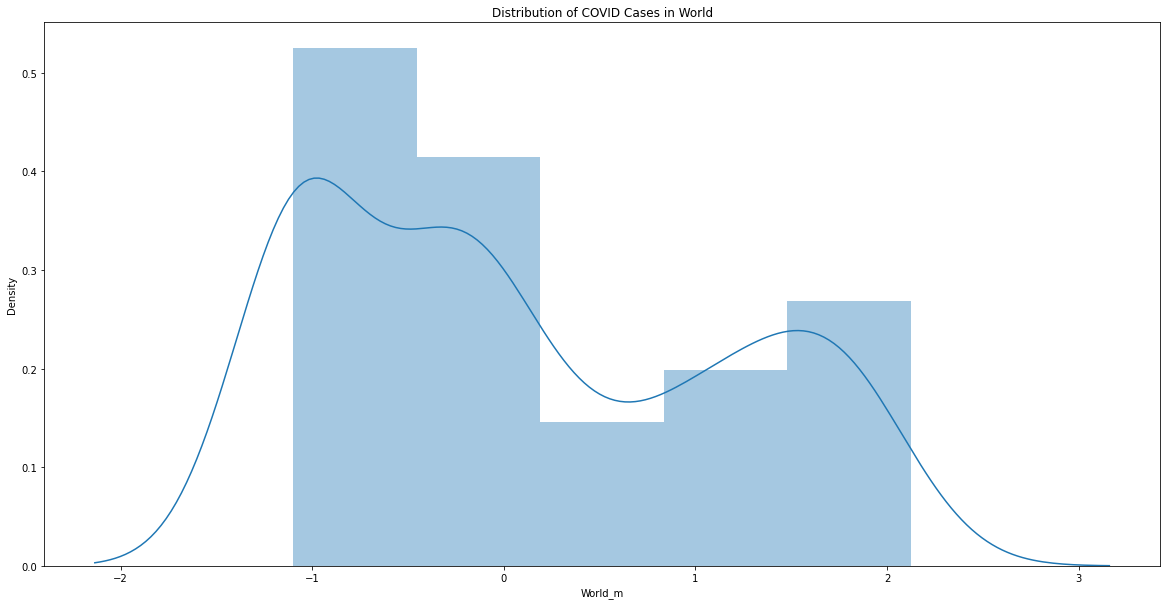

In [163]:
plt.figure(figsize=(20,10))
sns.distplot(df.World_m).set_title('Distribution of COVID Cases in World')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of COVID Cases in India')

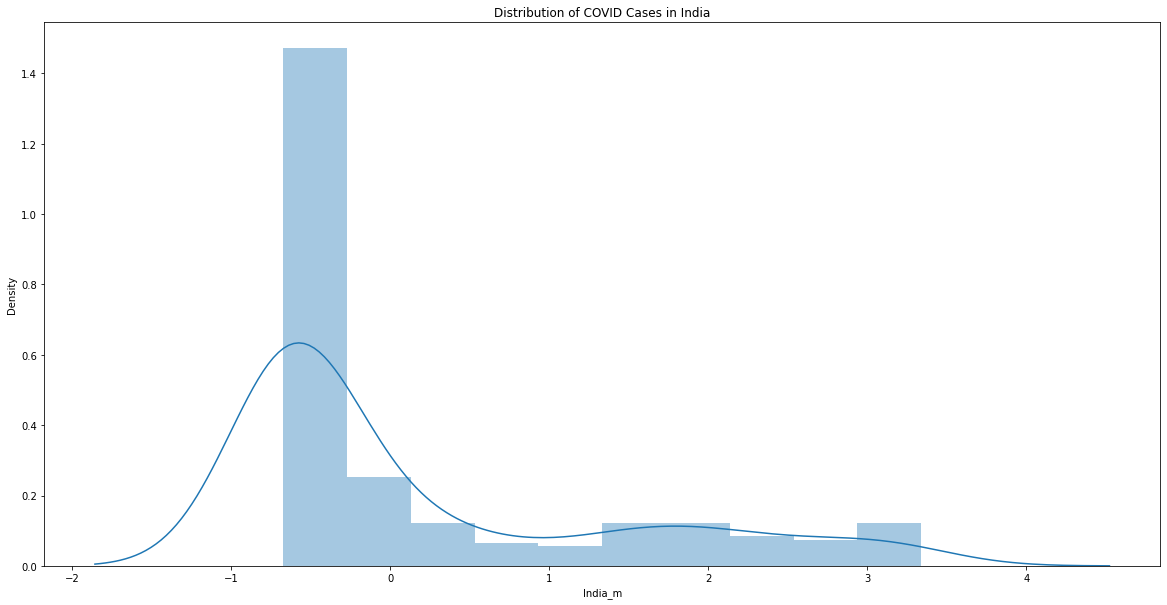

In [164]:
plt.figure(figsize=(20,10))
sns.distplot(df.India_m).set_title('Distribution of COVID Cases in India')

2. Scatter plot of the actual data

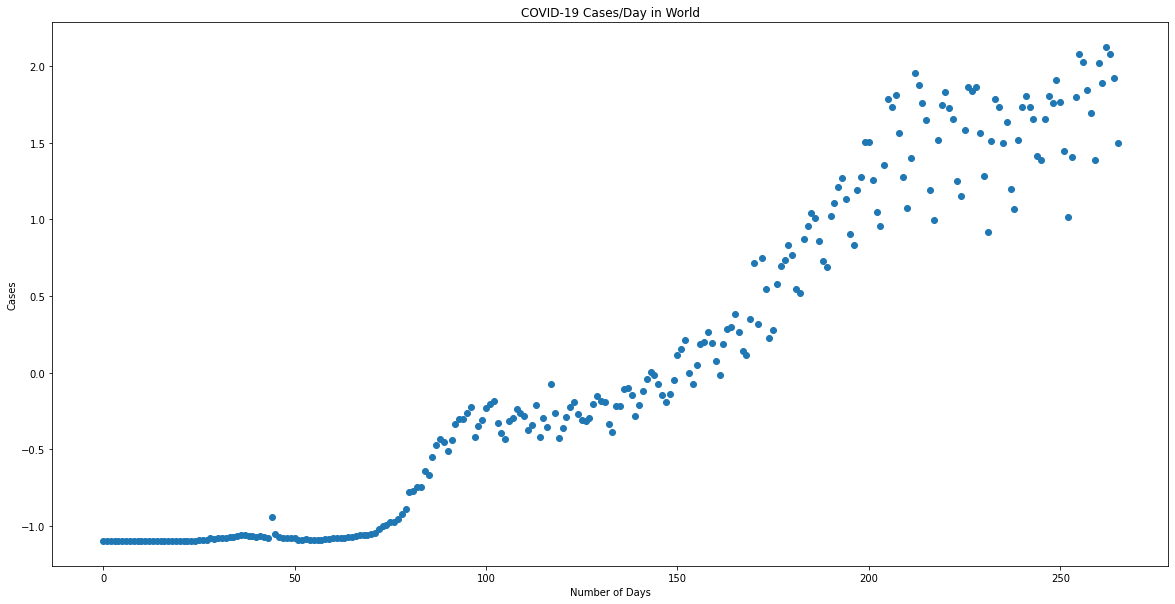

In [165]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.title('COVID-19 Cases/Day in World')
plt.xlabel('Number of Days')
plt.ylabel('Cases')
plt.scatter(df.index, df['World_m'])

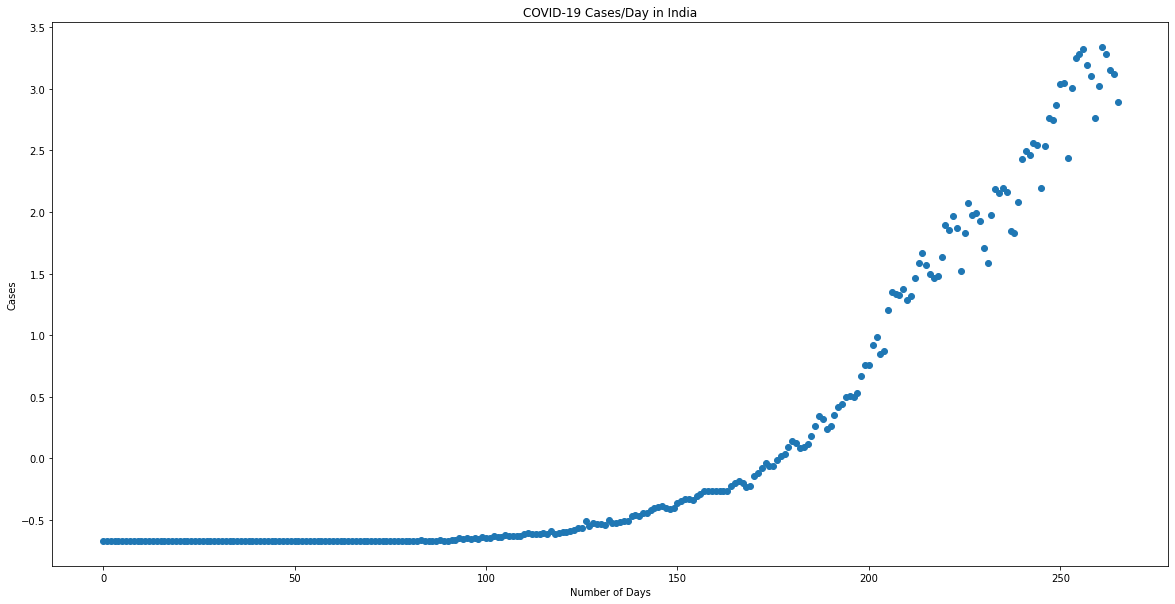

In [166]:
df.sort_values(by = 'Date', inplace = True)
fig, ax = plt.subplots(figsize=(20, 10))
plt.title('COVID-19 Cases/Day in India')
plt.xlabel('Number of Days')
plt.ylabel('Cases')
plt.scatter(df.index, df['India_m'])

**Splits**

1.  Train
2.  Test (Last 15)



In [167]:
df.set_index('Day', inplace=True, drop=True)

In [168]:
df.sort_values(by = 'Day', inplace=True)
y_train_i = df[:-15].India_m.values.tolist()
y_test_i = df[-15:].India_m.values.tolist()
x_train_i = df[:-15].index.values.tolist()
x_test_i = df[-15:].index.values.tolist()

In [169]:
y_train_w = df[:-15].World_m.values.tolist()
y_test_w = df[-15:].World_m.values.tolist()

# **Function Definitions**

**Plot Function**

**Plotting the Gaussian Process**
1. Here I have taken a function to plot the GP from a blog of Martin Krasser and tweaked it a bit for my use case

In [170]:
def plot_gps(mu, covar, X, X_train=None, Y_train=None, gt=None, samples=[]):
    
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(covar))
    
    fig, ax = plt.subplots(figsize=(20,10))

    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.2)
    plt.plot(X, mu, label='Mean')
    
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    
    if X_train is not None:
        plt.plot(X_train, Y_train, 'ro')
    if gt is not None:
      plt.scatter(X, gt, marker='x')
    plt.legend(bbox_to_anchor=(1.04,0.5),loc='center left')

**Kernel**

Here I have defined a Gaussian or Radial Basis Function Kernel.
1. The length parameter l controls the smoothness of the function
2. σf determines the vertical variation. 

For simplicity, we use the same length parameter l for all input dimensions (isotropic kernel).
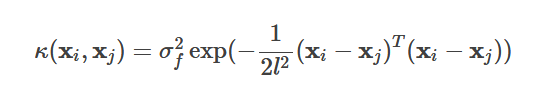

In [171]:
def kernel(X1, X2, l=5.0, sigma_f=1.0, kernel_type="rbf"):
  return sigma_f**2 * np.exp(-0.5 / l**2 * (np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)))

**Sufficient Statistics**

A GP prior **p(f|X)** can be converted into a GP posterior **p(f|X,y)** after having observed some data y. The posterior can then be used to make predictions f∗ given new input X∗

Here, I have defined a function that takes:
1. Xs (Newly Obs Data [in case of PPD] and Evidence in case of Posterior), 
2. X_train, Y_train
3. l = length parameter of the kernel
4. sigma_f = sigma of the kernel
5. sigma_y = noise_parameter

The function helps us to predict the new mean and covariance matrix for the posterior after it sees some present data y and modifies itself from a prior.

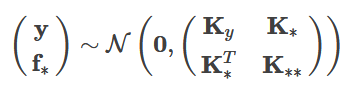

With N training data and N∗ new input data.

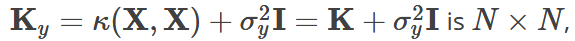

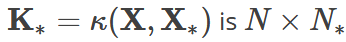

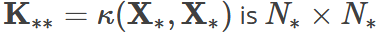

(σy)^2 is the noise term in the diagonal of Ky.

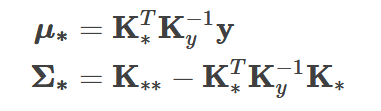

In [172]:
def sufficient_statistics(Xs, X, Y, l=1.0, sigma_f=1.0, sigma_y=1.0,prior="rbf"):
    Ky = kernel(X,X,l,sigma_f,kernel_type=prior) + sigma_y**2*np.eye(len(X))
    Ks = kernel(X,Xs, l, sigma_f,kernel_type=prior)
    Kss = kernel(Xs,Xs, l ,sigma_f,kernel_type=prior)+ 1e-5 * np.eye(len(Xs))

    # mean 
    mu = Ks.T.dot(np.linalg.inv(Ky)).dot(Y)
    # covariance 
    covar = Kss - Ks.T.dot(np.linalg.inv(Ky)).dot(Ks)
    return mu, covar

**Hyperparameter Optimization Function**

The goodness of fit depends heavily on the Kernel function. However, even more important is the right choice of hyperparameters, as the kernel functions themselves are indeed quite flexible. 

Optimising the log marginal likelihood.
The standard form of the log-likelihood function for a multivariate gaussian is as follows:

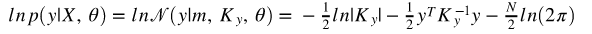

Finding the values for our hyperparameters that minimise this function is an optimisation problem, so we're gonna need its gradient:

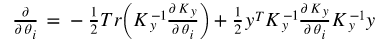

I have used the BFGS (Broyden–Fletcher–Goldfarb–Shannon) method to optimise the Negative Log Likelihood function for its hyperparameters, using predefined library function.

In [173]:
def NegLoglik(X_train, Y_train, noise):
    
    def loss(theta):        
        K = kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + noise**2 * np.eye(len(X_train))
        L = cholesky(K)
        return np.sum(np.log(np.diagonal(L))) + 0.5 * Y_train.T.dot(lstsq(L.T, lstsq(L, Y_train,rcond=None)[0],rcond=None)[0]) +  0.5 * len(X_train) * np.log(2*np.pi)
    
    return loss

**Root Mean Squared Error**

*   This function is being used to determined the RMSE between the predicted values and the ground truth.





In [174]:
def r2_val(y_true, y_pred):
  return mean_squared_error(y_true, y_pred,squared=False)

# **Gaussian Process Regression**

**Prior**

A prior pdf on a parameter θ ∈ Θ that indexes a statistical model X ∼ p(x|θ),
reflects the analyst’s pre-data understanding/ knowledge /belief about θ. When θ is
an interpretable quantity, “belief about θ” is tangible. Example: θ = proportion of
students in support of a university policy. If θ is merely an artifact of our formalization
of X through the pdfs p(x|θ), then belief about θ really means belief about X consistent
with the statistical model. Example: Xi = increase in sleep hours, Xi
IID∼ N(µ, σ2
).

Here we are having Xi as the number of days, hence θ is a formalization of X and hence assuming a gaussian prior with X ∼ N(µ, σ2)

In [175]:
X = np.array(x_train_i).reshape(-1, 1)
Xs = np.array(x_test_i).reshape(-1, 1)

X_train = X
Y_train = np.array(y_train_i).reshape(-1, 1)

################################### PRIOR ################################################
#Defining m(x) = 0 as mean function and K(X,X) as covariance function of the assumed prior
mu = np.zeros(X.shape) #Prior_mean
#l and sigma_f are randomly chosen through hit and trials
covar = kernel(X, X, l=27, sigma_f = 0.08) ##Prior_Covariance

Text(0.5, 1.0, 'Covariance Matrix of the Prior')

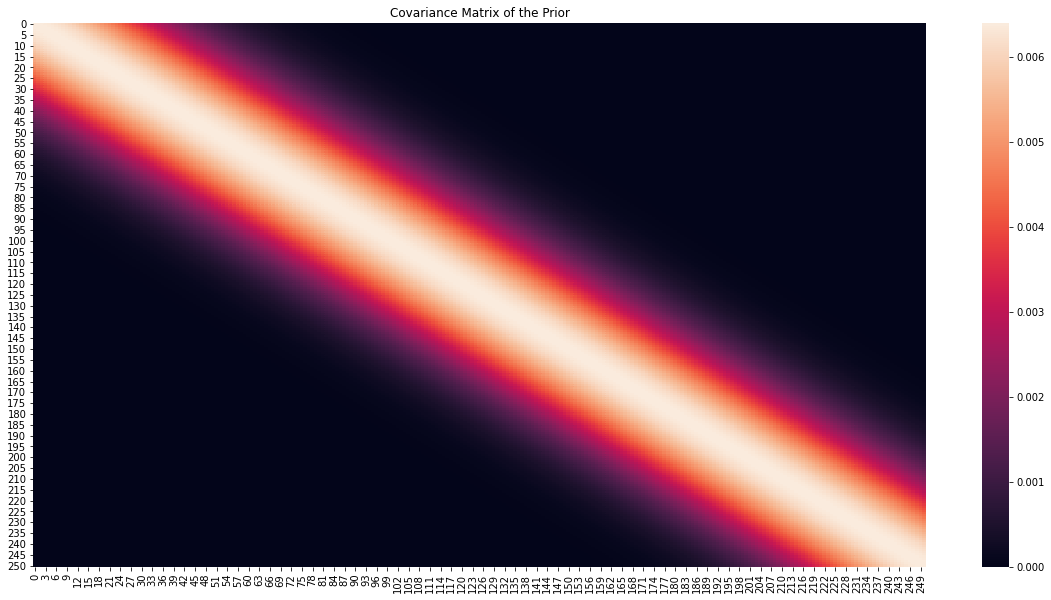

In [176]:
plt.figure(figsize=(20,10))
sns.heatmap(covar).set_title('Covariance Matrix of the Prior')

A kernel (or covariance function) describes the covariance of the Gaussian process random variables. Together with the mean function the kernel completely defines a Gaussian process.

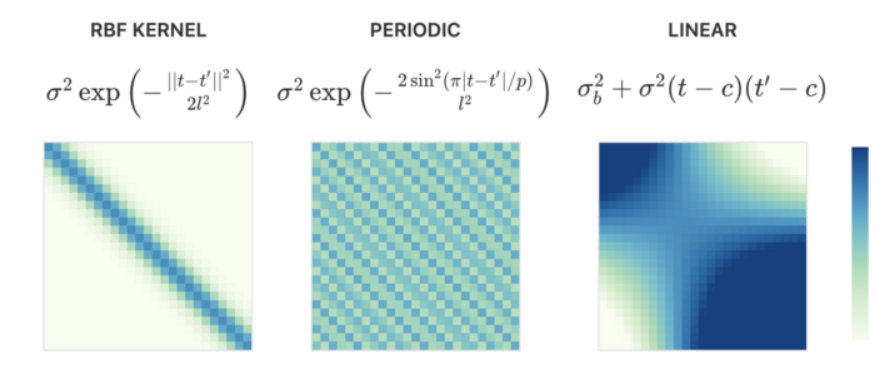

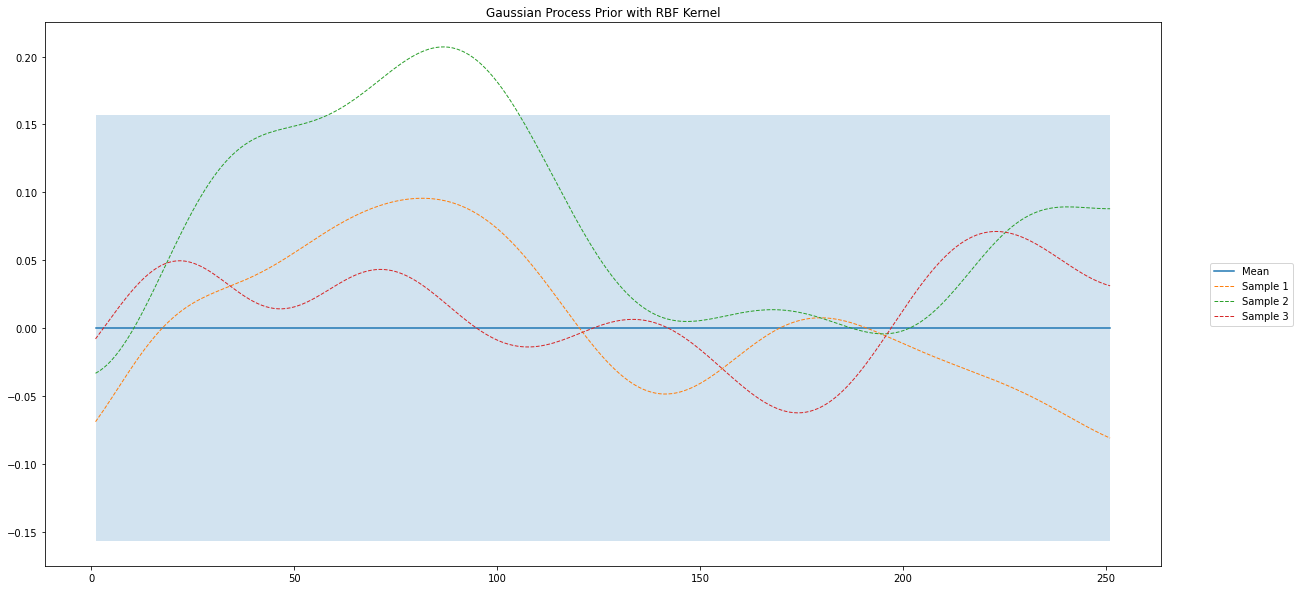

In [177]:
samples = np.random.multivariate_normal(mu.ravel(),covar,3) #sampling 3 samples from the prior

plot_gps(mu, covar, X, samples=samples)
plt.title('Gaussian Process Prior with RBF Kernel')
plt.show()

# **COVID-19 Cases - India**

1. **Posterior**

Here we arrive at a posterior by using Y as the observed data that modifies the mean function and variance and hence obtain a certain fit.

With our training dataset (x,y) we can then obtain the posterior (y or f(x), since y=f(x)+noise).

For the given noise value we arrive at this result where we are getting this posterior distribution which has been found out by hit and trials over a certain coarse steps for length and small steps for noise differing by 0.1.
The values of sigma_f and l have been manually chose through hit and trial in this plots, no optumization.


Text(0.5, 1.0, 'Posterior Predictive Distribution of GP with RBF Kernel')

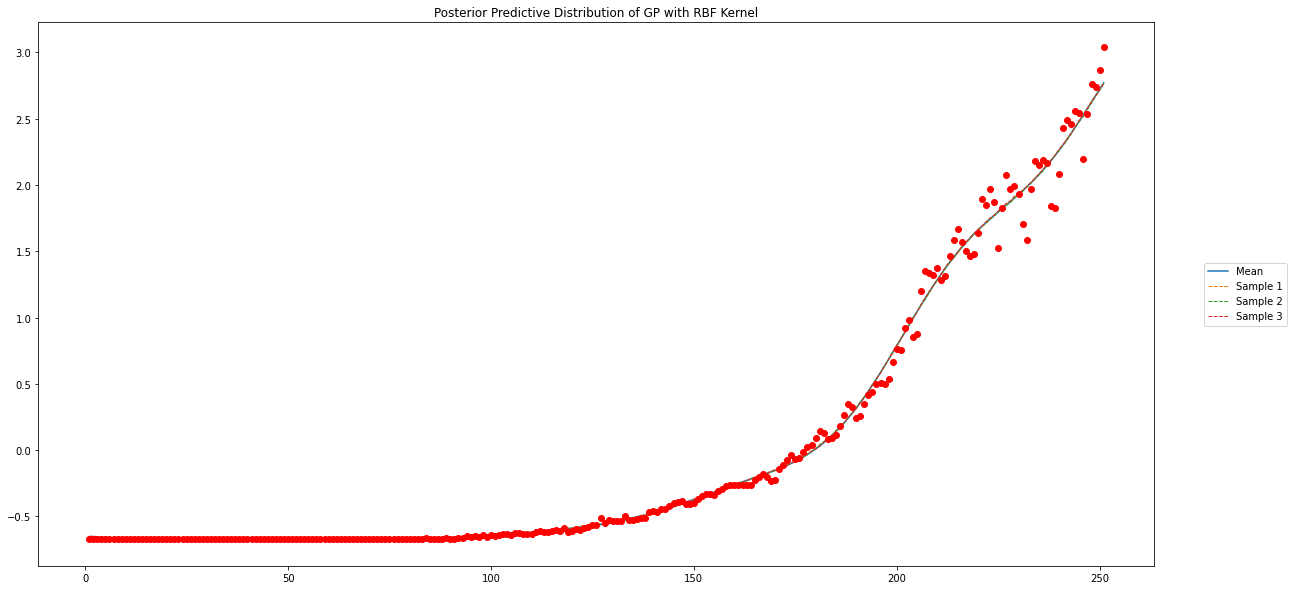

In [178]:
mu, covar = sufficient_statistics(X, X_train, Y_train, l=27, sigma_f = 0.1, sigma_y=0.02, prior="rbf") #Here X = X_train

samples = np.random.multivariate_normal(mu.ravel(), covar, 3) #Sampling
plot_gps(mu, covar, X, X_train=X_train, Y_train=Y_train, samples=samples) #plot
plt.title('Posterior Predictive Distribution of GP with RBF Kernel')

2. **Posterior Predictive Distribution** 

Using the same values as above, we now introduce the value of X* (our test case) to arrive at our PPD using the sufficient statistics. Though, this model is not presenting the best fit or the best and optimized hyperparameters. The values of sigma_f and l have been manually chose through hit and trial in this plots, no optumization.

The function sufficient_statistics determines the posterior predictive here by using the new points (test point), training data and target values (y), P(f* | X*, X, y).

Mean Squared Error =  0.2336073248895778


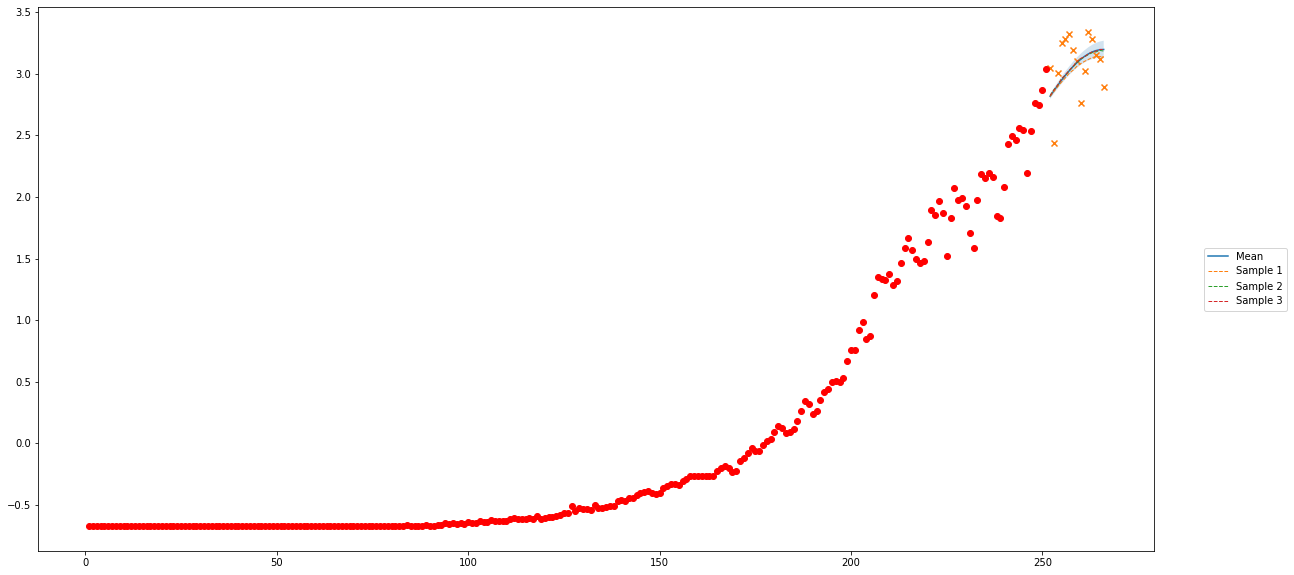

In [179]:
mu, covar = sufficient_statistics(Xs, X_train, Y_train, l=27, sigma_f = 0.1, sigma_y=0.02, prior="rbf") #Here X = Xs (New points for prediction)
gt = np.array(y_test_i).reshape(-1,1) #Ground Truth Data of Inida (Standardised)

samples = np.random.multivariate_normal(mu.ravel(), covar, 3)
plot_gps(mu, covar, Xs, X_train=X_train, Y_train=Y_train, gt=gt, samples=samples)
print("Mean Squared Error = ", r2_val(gt.reshape(-1, 1), mu.reshape(-1, 1)))

3. **Hyper-Parameter Optimization**

Here we use the function defined above for hyperparameter tuning for a certain value of noise to obtain point estimates of the parameters sigma_kernel and length as sf_hat and l_hat and plot the best fits for both the train and predicted mu for test data of 15 days.

1. This piece of code makes use of the NegLoglik function defined above and minimizes it for each value of noise, and finds the optimal sigma_f_heat and l_hat. The value for which we get the least RMSE, is chosen as the value of the noise and is used in the next cell to plot the gaussian for the test cases.
A plot is also there which presents RMSE vs noise data.

Noise =  0.02040816326530612
Best Fit Length = 1.9451578293564202 and Best Fit Sigma of Kernel = 0.7308321598410752
Mean Squared Error =  2.8556501005137864
Noise =  0.04081632653061224
Best Fit Length = 3.7423489467254436 and Best Fit Sigma of Kernel = 0.805431849674257
Mean Squared Error =  2.312529925269975
Noise =  0.061224489795918366
Best Fit Length = 3.812506945742852 and Best Fit Sigma of Kernel = 0.7894377678116982
Mean Squared Error =  2.4046733286246664
Noise =  0.08163265306122448
Best Fit Length = 3.9994925954014975 and Best Fit Sigma of Kernel = 0.7749427336796554
Mean Squared Error =  2.433985898550648
Noise =  0.12244897959183673
Best Fit Length = 29.928321486404993 and Best Fit Sigma of Kernel = 1.4989598277501213
Mean Squared Error =  0.538751487611506
Noise =  0.14285714285714285
Best Fit Length = 31.06841403119629 and Best Fit Sigma of Kernel = 1.483460559699239
Mean Squared Error =  0.46159755213714654
Noise =  0.16326530612244897
Best Fit Length = 32.4956190655434

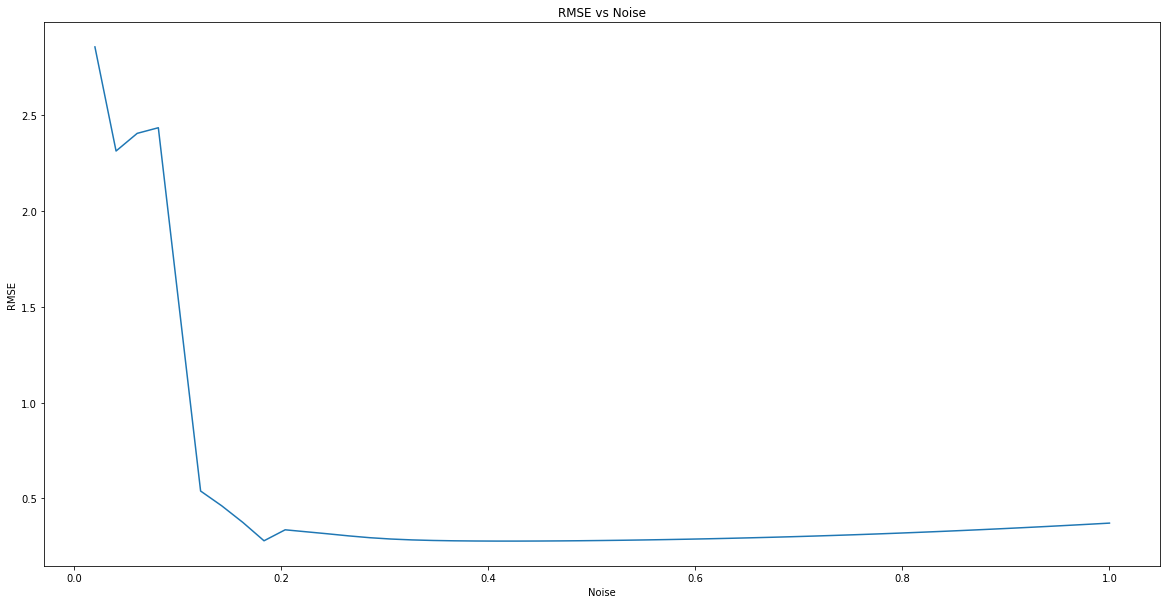

In [180]:
n=[]
mse=[]
for noise in np.linspace(0,1,50): 
  try:
    res = minimize(NegLoglik(X_train, Y_train, noise), [1, 1], bounds=((1e-5, None), (1e-5, None)), method='L-BFGS-B')
    l_hat, sigma_f_hat = res.x
    print("Noise = ", noise)
    print("Best Fit Length = {} and Best Fit Sigma of Kernel = {}".format(l_hat, sigma_f_hat))
    m_s, K_s = sufficient_statistics(Xs, X_train, Y_train, l=l_hat, sigma_f=sigma_f_hat, sigma_y=noise)
    mser =  r2_val(gt.reshape(-1, 1), m_s.reshape(-1, 1))
    print("Mean Squared Error = ", mser)
    n.append(noise)
    mse.append(mser)
  except:
    pass
fig, ax = plt.subplots(figsize=(20,10))
plt.title('RMSE vs Noise')
plt.ylabel('RMSE')
plt.xlabel('Noise')
plt.plot(n, mse)

en_data = pd.DataFrame(list(zip(n, mse)), columns=['Noise', 'RMSE'])
print("Minimum RMSE at Noise val\n",en_data[en_data['RMSE'] == en_data['RMSE'].min()])

2. This part of the cell is to find the sigma_f_hat and l_hat as point estimates thtough negative log likelihood minimization, and is fed the value of noise for which we get the best possible regression RMSE.

Noise =  0.4
Best Fit Length = 86.71766450130893 and Best Fit Sigma of Kernel = 1.791954882696292
Mean Squared Error =  0.27770485984545634


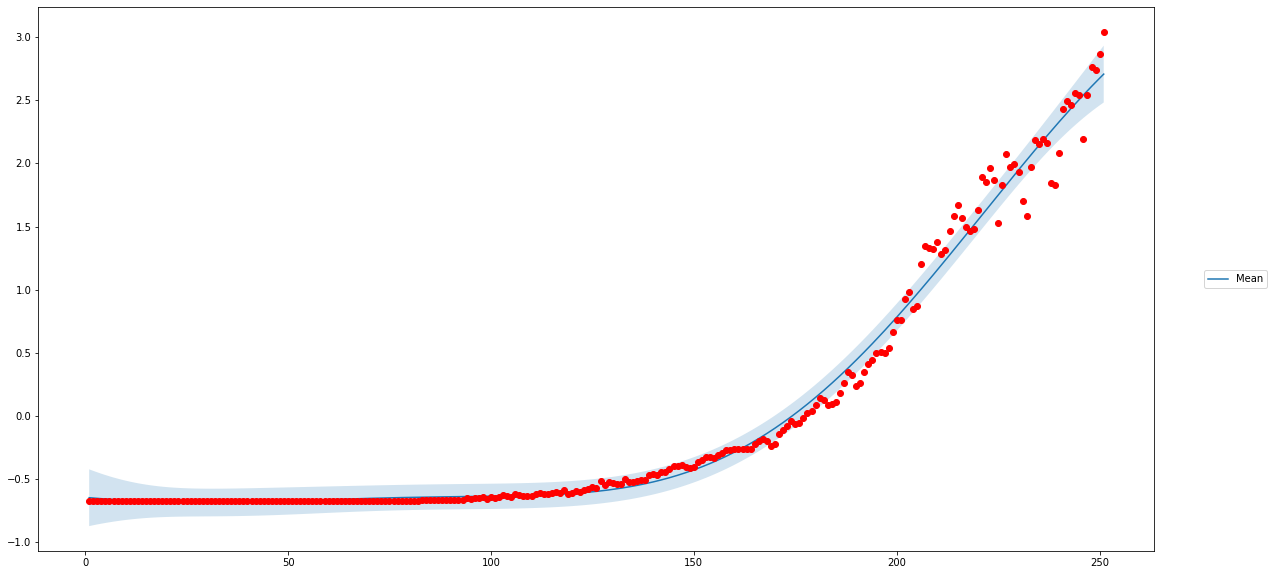

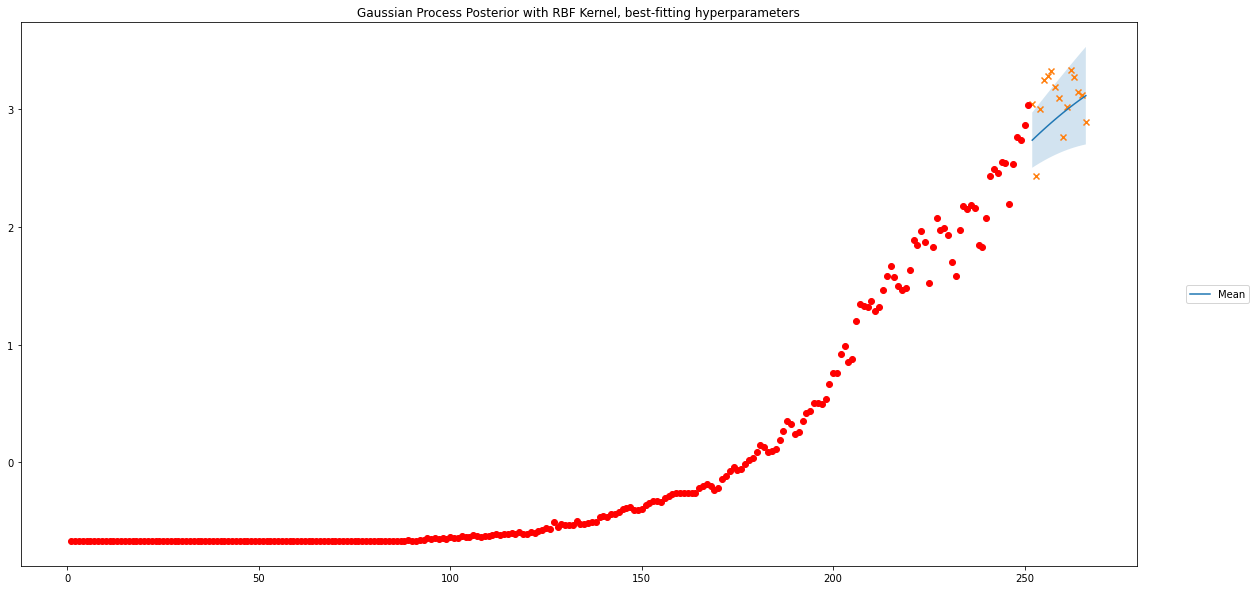

In [181]:
noise = 0.4
res = minimize(NegLoglik(X_train, Y_train, noise), [1, 1], bounds=((1e-5, None), (1e-5, None)), method='L-BFGS-B')

l_hat, sigma_f_hat = res.x #Optimal_hyperparams

print("Noise = ", noise)
print("Best Fit Length = {} and Best Fit Sigma of Kernel = {}".format(l_hat, sigma_f_hat))

m, K = sufficient_statistics(X, X_train, Y_train, l=l_hat, sigma_f=sigma_f_hat, sigma_y=noise)

m_s, K_s = sufficient_statistics(Xs, X_train, Y_train, l=l_hat, sigma_f=sigma_f_hat, sigma_y=noise)

plot_gps(m, K, X_train, X_train=X_train, Y_train=Y_train)
plot_gps(m_s, K_s, Xs, X_train=X_train, Y_train=Y_train, gt=gt)

plt.title('Gaussian Process Posterior with RBF Kernel, best-fitting hyperparameters')
print("Mean Squared Error = ", r2_val(gt.reshape(-1, 1), m_s.reshape(-1, 1)))

# **For World Data**

1. **Posterior**

Here we arrive at a posterior by using Y as the observed data that modifies the mean function and variance and hence obtain a certain fit.

For the given noise value we arrive at this result where we are getting this posterior distribution which has been found out by hit and trials over a certain coarse steps for length and small steps for noise differing by 0.1.
The values of sigma_f and l have been manually chose through hit and trial in this plots, no optumization.


Text(0.5, 1.0, 'Posterior Distribution of GP with RBF Kernel')

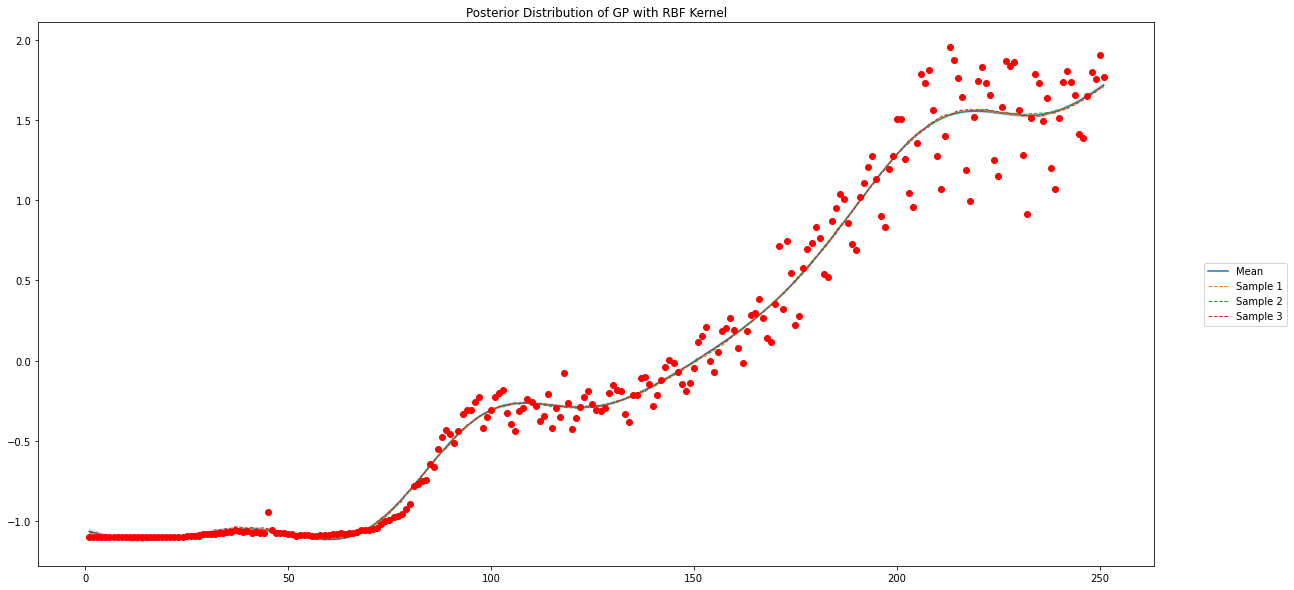

In [182]:
Y_train = np.array(y_train_w).reshape(-1, 1)

mu, covar = sufficient_statistics(X, X_train, Y_train, l=27, sigma_f = 0.1, sigma_y=0.02, prior="rbf")

samples = np.random.multivariate_normal(mu.ravel(), covar, 3)
plot_gps(mu, covar, X, X_train=X_train, Y_train=Y_train, samples=samples)
plt.title('Posterior Distribution of GP with RBF Kernel')

2. **Posterior Predective Distribution** 

Using the same values as above, we now introduce the value of X* (our test case) to arrive at our PPD using the sufficient statistics. Though, this model is not presenting the best fit or the best and optimized hyperparameters. The values of sigma_f and l have been manually chose through hit and trial in this plots, no optumization.

Text(0.5, 1.0, 'Posterior Predictive Distribution of GP with RBF Kernel')

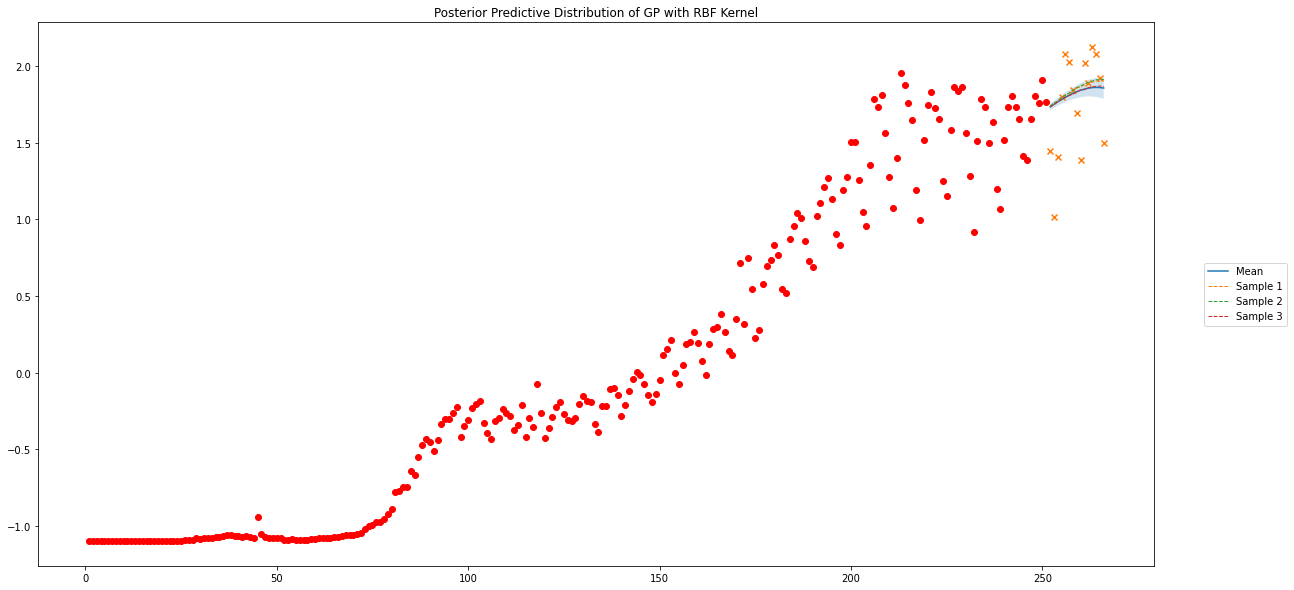

In [183]:
mu, covar = sufficient_statistics(Xs, X_train, Y_train, l=27, sigma_f = 0.1, sigma_y=0.02, prior="rbf")
gt = np.array(y_test_w).reshape(-1,1) #Ground Truth Data of World (Standardised)

samples = np.random.multivariate_normal(mu.ravel(), covar, 3)
plot_gps(mu, covar, Xs, X_train=X_train, Y_train=Y_train, gt=gt, samples=samples)
plt.title('Posterior Predictive Distribution of GP with RBF Kernel')

3. **Hyper-Parameter Optimization**

Here we use the function defined above for hyperparameter tuning for a certain value of noise to obtain point estimates of the parameters sigma_kernel and length as sf_hat and l_hat and plot the best fits for both the train and predicted mu for test data of 15 days.

1. This piece of code makes use of the NegLoglik function defined above and minimizes it for each value of noise, and finds the optimal sigma_f_heat and l_hat. The value for which we get the least RMSE, is chosen as the value of the noise and is used in the next cell to plot the gaussian for the test cases.
A plot is also there which presents RMSE vs noise data.

Noise =  0.0
Best Fit Length = 1.2822227478736015 and Best Fit Sigma of Kernel = 0.7226949391658551
Mean Squared Error =  1.7260516236672443
Noise =  0.02040816326530612
Best Fit Length = 1.3425704414524007 and Best Fit Sigma of Kernel = 0.718790933841839
Mean Squared Error =  1.7245444135891972
Noise =  0.04081632653061224
Best Fit Length = 1.9194698349713195 and Best Fit Sigma of Kernel = 0.7558789574421227
Mean Squared Error =  1.7141362185144708
Noise =  0.061224489795918366
Best Fit Length = 3.2585749991483475 and Best Fit Sigma of Kernel = 0.8514599607483889
Mean Squared Error =  1.5486994122848277
Noise =  0.08163265306122448
Best Fit Length = 3.2607894337031187 and Best Fit Sigma of Kernel = 0.8452278497895647
Mean Squared Error =  1.5624812073274952
Noise =  0.1020408163265306
Best Fit Length = 3.2644606044578732 and Best Fit Sigma of Kernel = 0.8378482934798991
Mean Squared Error =  1.5735511030528326
Noise =  0.12244897959183673
Best Fit Length = 3.275525198041623 and Best F

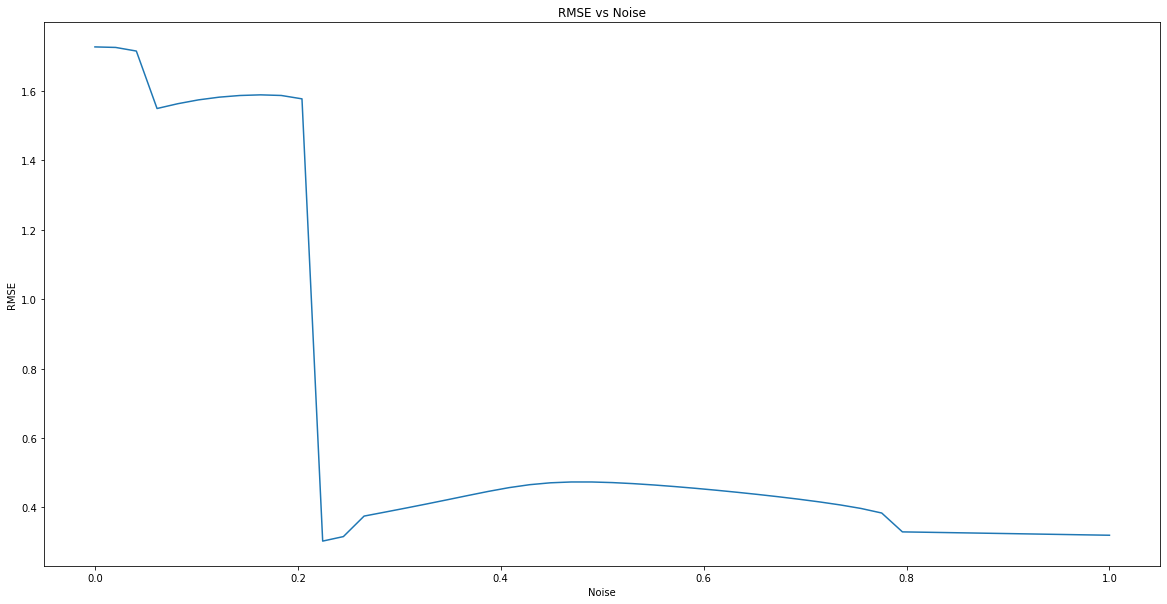

In [184]:
n=[]
mse=[]
for noise in np.linspace(0,1,50): 
  try:
    res = minimize(NegLoglik(X_train, Y_train, noise), [1, 1], bounds=((1e-5, None), (1e-5, None)), method='L-BFGS-B')
    l_hat, sigma_f_hat = res.x
    print("Noise = ", noise)
    print("Best Fit Length = {} and Best Fit Sigma of Kernel = {}".format(l_hat, sigma_f_hat))
    m_s, K_s = sufficient_statistics(Xs, X_train, Y_train, l=l_hat, sigma_f=sigma_f_hat, sigma_y=noise)
    mser =  r2_val(gt.reshape(-1, 1), m_s.reshape(-1, 1))
    print("Mean Squared Error = ", mser)
    n.append(noise)
    mse.append(mser)
  except:
    pass
fig, ax = plt.subplots(figsize=(20,10))
plt.title('RMSE vs Noise')
plt.xlabel('Noise')
plt.ylabel('RMSE')
plt.plot(n, mse)

en_data = pd.DataFrame(list(zip(n, mse)), columns=['Noise', 'RMSE'])
print("Minimum RMSE at Noise val\n",en_data[en_data['RMSE'] == en_data['RMSE'].min()])

2. This part of the cell is to find the sigma_f_hat and l_hat as point estimates thtough negative log likelihood minimization, and is fed the value of noise for which we get the best possible regression RMSE.

Noise =  0.225
Best Fit Length = 32.60975795213283 and Best Fit Sigma of Kernel = 0.9139682938544009
Mean Squared Error =  0.3034630676419458


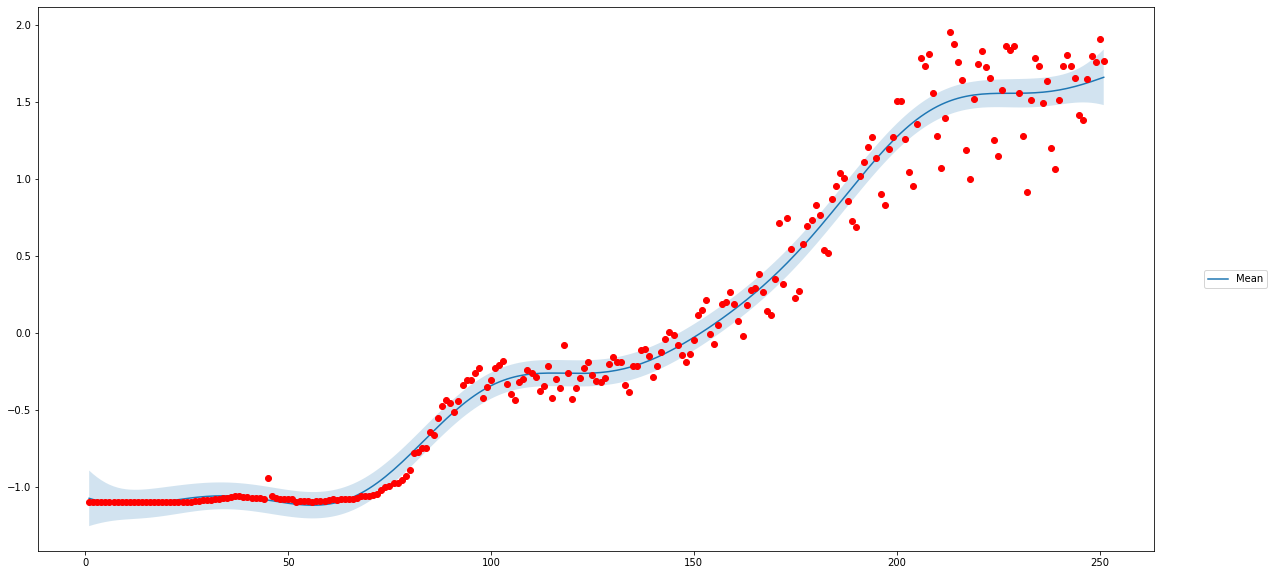

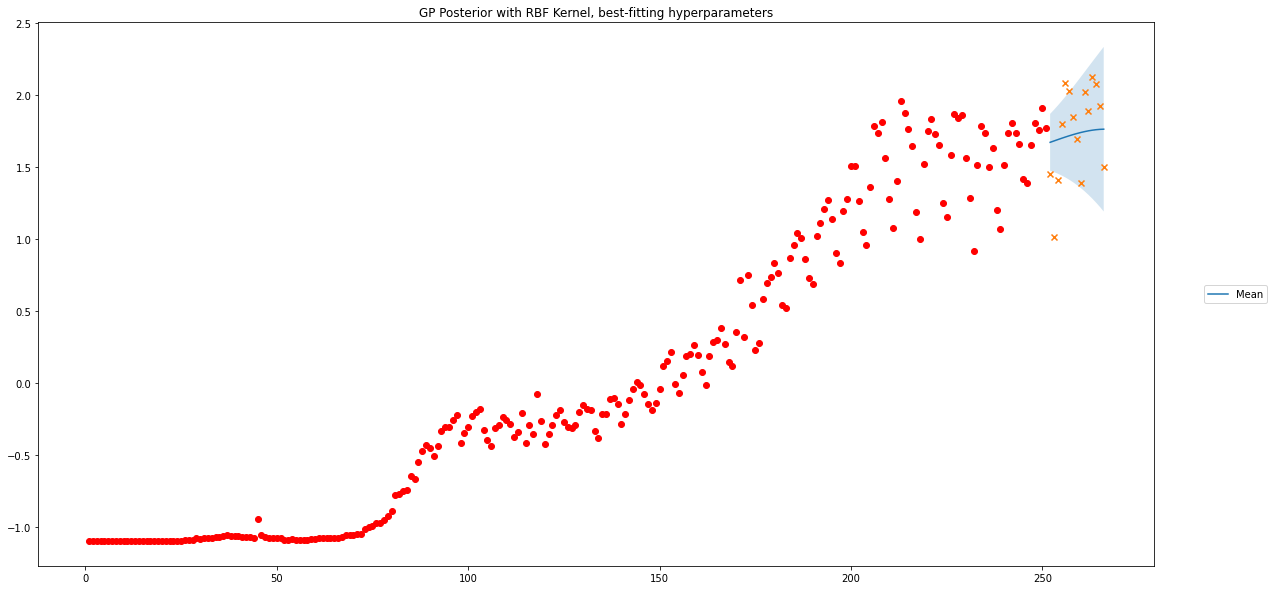

In [185]:
noise = 0.225

res = minimize(NegLoglik(X_train, Y_train, noise), [1, 1], bounds=((1e-8, None), (1e-8, None)), method='L-BFGS-B')

l_hat, sigma_f_hat = res.x #Optimal_hyperparams

print("Noise = ", noise)
print("Best Fit Length = {} and Best Fit Sigma of Kernel = {}".format(l_hat, sigma_f_hat))

m, K = sufficient_statistics(X, X_train, Y_train, l=l_hat, sigma_f = sigma_f_hat, sigma_y=noise)

m_s, K_s = sufficient_statistics(Xs, X_train, Y_train, l=l_hat, sigma_f = sigma_f_hat, sigma_y=noise)

plot_gps(m, K, X_train, X_train=X_train, Y_train=Y_train)
plot_gps(m_s, K_s, Xs, X_train=X_train, Y_train=Y_train, gt=gt)

plt.title('GP Posterior with RBF Kernel, best-fitting hyperparameters')
print("Mean Squared Error = ", r2_val(gt.reshape(-1, 1), m_s.reshape(-1, 1)))